In [1]:
from utils import CNNBackbone, ASTBackbone, get_device, SpectrogramDataset, CLASS_MAPPING, torch_train_val_split, \
    Classifier, free_gpu_memory, LSTMBackbone
import torch
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import numpy as np
import os

%matplotlib inline

# DATA_PATH = "/home/alex/Downloads/archive(1)/data/"
DATA_PATH = os.path.join(os.getcwd(), "data/")
model_weights_path = os.path.join(os.getcwd(), "model_weights/")
assets_path = os.path.join(os.getcwd(), "assets/")

mel_specs_path = DATA_PATH + "fma_genre_spectrograms/"
beat_mel_specs_path = DATA_PATH + "fma_genre_spectrograms_beat/"
os.makedirs(model_weights_path, exist_ok=True)
os.makedirs(assets_path, exist_ok=True)

EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 8
RANDOM_SEED = 42
RNN_HIDDEN_SIZE = 256
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 256
NUM_LAYERS = 8

if torch.cuda.is_available():
    print(f"Detected GPU: {torch.cuda.get_device_name(0)}")
    print(f"Free GPU Memory: {free_gpu_memory():.2f}%")
else:
    print("CUDA is not available. No compatible GPU detected.")
DEVICE = get_device()

Detected GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Free GPU Memory: 100.00%


In [2]:
def extract_latent_representations(model, dataloader, device, regression_flag):
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for x, y, lengths in dataloader:
            x = x.float().to(device)
            y = y.float().to(device) if regression_flag else y.to(device)
            lengths = lengths.to(device)
            
            # Forward pass
            _, logits = model(x, y, lengths)
            
            # Collect latent vectors and labels
            latent_vectors.append(logits.cpu().numpy())
            labels.append(y.cpu().numpy())
    
    latent_vectors = np.vstack(latent_vectors)
    labels = np.hstack(labels)
    return latent_vectors, labels

def plot_latent_representation(model_name, latent_vectors, labels):
    # Set up the grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"{model_name} Dimensionality Reduction Visualizations", fontsize=16)
    
    # PCA
    pca = PCA(n_components=2)
    reduced_pca = pca.fit_transform(latent_vectors)
    axes[0, 0].scatter(reduced_pca[:, 0], reduced_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[0, 0].set_title("PCA")
    axes[0, 0].set_xlabel("Component 1")
    axes[0, 0].set_ylabel("Component 2")
    
    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    reduced_tsne = tsne.fit_transform(latent_vectors)
    axes[0, 1].scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[0, 1].set_title("t-SNE")
    axes[0, 1].set_xlabel("Dimension 1")
    axes[0, 1].set_ylabel("Dimension 2")
    
    # UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=-1)
    reduced_umap = reducer.fit_transform(latent_vectors)
    axes[0, 2].scatter(reduced_umap[:, 0], reduced_umap[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[0, 2].set_title("UMAP")
    axes[0, 2].set_xlabel("Dimension 1")
    axes[0, 2].set_ylabel("Dimension 2")
    
    # Spectral Embedding
    spectral = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=10)
    reduced_spectral = spectral.fit_transform(latent_vectors)
    axes[1, 0].scatter(reduced_spectral[:, 0], reduced_spectral[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[1, 0].set_title("Spectral Embedding")
    axes[1, 0].set_xlabel("Component 1")
    axes[1, 0].set_ylabel("Component 2")
    
    # ISOMAP
    isomap = Isomap(n_neighbors=10, n_components=2)
    reduced_isomap = isomap.fit_transform(latent_vectors)
    axes[1, 1].scatter(reduced_isomap[:, 0], reduced_isomap[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[1, 1].set_title("ISOMAP")
    axes[1, 1].set_xlabel("Dimension 1")
    axes[1, 1].set_ylabel("Dimension 2")
    
    # MDS
    mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
    reduced_data = mds.fit_transform(latent_vectors)
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[1, 2].set_title("MDS Visualization")
    axes[1, 2].set_xlabel("Dimension 1")
    axes[1, 2].set_ylabel("Dimension 2")
            
    # bottom shared horizontal color bar
    colorbar_ax = fig.add_axes([0.2, -0.02, 0.62, 0.02])  
    colorbar = fig.colorbar(scatter, cax=colorbar_ax, orientation='horizontal')
    colorbar.set_label("Classes")

    plt.show()

In [3]:
mel_specs_test_data = SpectrogramDataset(mel_specs_path, class_mapping=CLASS_MAPPING, train=False)
mel_specs_test_dl, _ = torch_train_val_split(dataset=mel_specs_test_data, batch_eval=BATCH_SIZE, batch_train=BATCH_SIZE, val_size=.0, shuffle=False)

mel_specs_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=CLASS_MAPPING, train=True)
mel_specs_train_dl, mel_specs_val_dl = torch_train_val_split(dataset=mel_specs_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)

x_b1, _, _ = next(iter(mel_specs_train_dl))
input_shape = x_b1[0].shape

#### Extract the latent representations of the test data from the best pretrained LSTM model and visualize them using dimensionality reduction techniques

In [4]:
backbone = LSTMBackbone(mel_specs_test_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
lstm = Classifier(NUM_CATEGORIES, backbone).to(DEVICE)
lstm.load_state_dict(torch.load(model_weights_path+"lstm_genre_mel.pth", weights_only=True))  # Load state_dict

<All keys matched successfully>

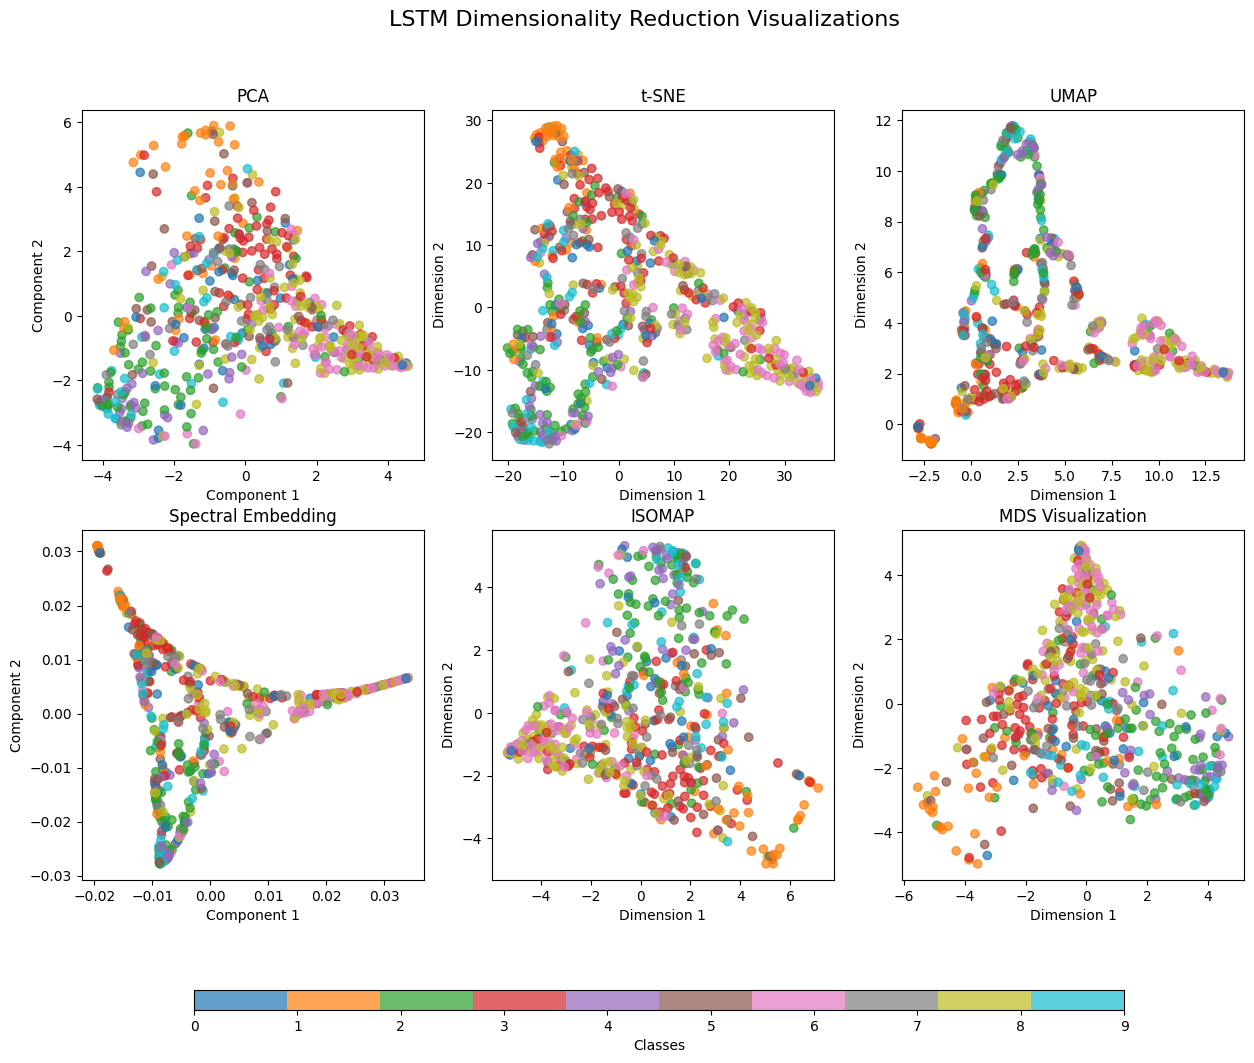

In [5]:
lstm_latent_vectors, labels = extract_latent_representations(lstm, mel_specs_test_dl, DEVICE, False)

plot_latent_representation("LSTM", lstm_latent_vectors, labels)

#### Extract the latent representations of the test data from the best pretrained CNN model and visualize them using dimensionality reduction techniques

In [6]:

# train / val
mel_specs_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=CLASS_MAPPING, train=True)
mel_specs_train_dl, mel_specs_val_dl = torch_train_val_split(dataset=mel_specs_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)
# test
x_b1, _, _ = next(iter(mel_specs_train_dl))
input_shape = x_b1[0].shape
print("input_dims:", input_shape)

input_dims: torch.Size([1293, 128])


In [7]:
backbone = CNNBackbone(input_dims=input_shape, in_channels=cnn_in_channels, filters=cnn_filters, feature_size=cnn_out_feature_size)

cnn = Classifier(NUM_CATEGORIES, backbone).to(DEVICE)
cnn.load_state_dict(torch.load(model_weights_path+"cnn_genre_mel.pth", weights_only=True))  # Load state_dict

<All keys matched successfully>

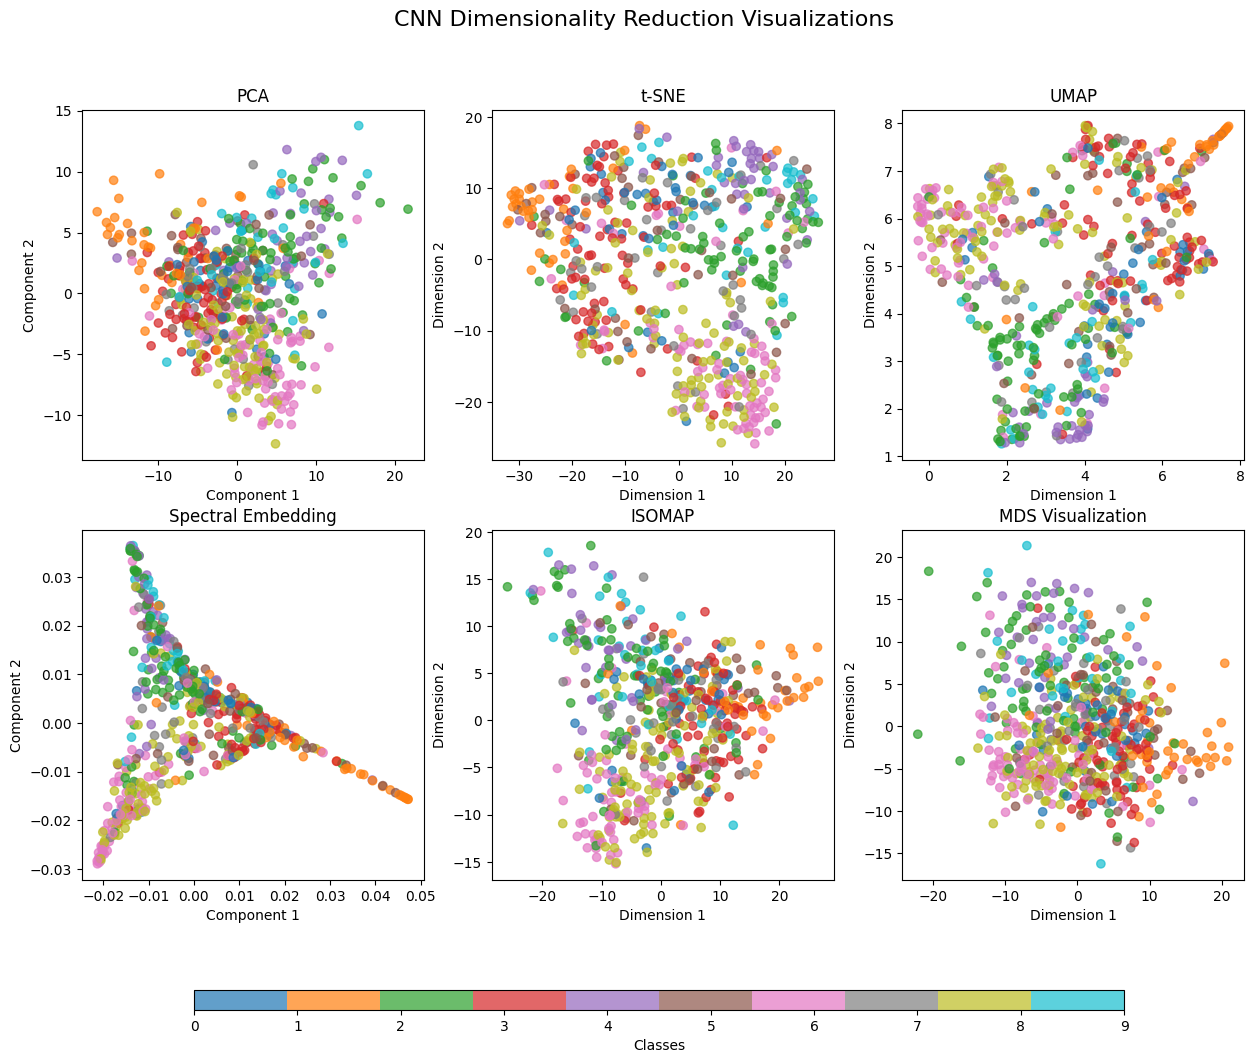

In [8]:
cnn_latent_vectors, labels = extract_latent_representations(cnn, mel_specs_test_dl, DEVICE, False)

plot_latent_representation("CNN", cnn_latent_vectors, labels)

#### Extract the latent representations of the test data from the best pretrained AST model and visualize them using dimensionality reduction techniques

In [9]:
backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=input_shape[1],
    input_tdim=input_shape[0],
    imagenet_pretrain=True,
    model_size='tiny224',
    feature_size=NUM_CATEGORIES,
)

ast = Classifier(NUM_CATEGORIES, backbone).to(DEVICE)
ast.load_state_dict(torch.load(model_weights_path+"ast_genre_mel.pth", weights_only=True))  # Load state_dict

<All keys matched successfully>

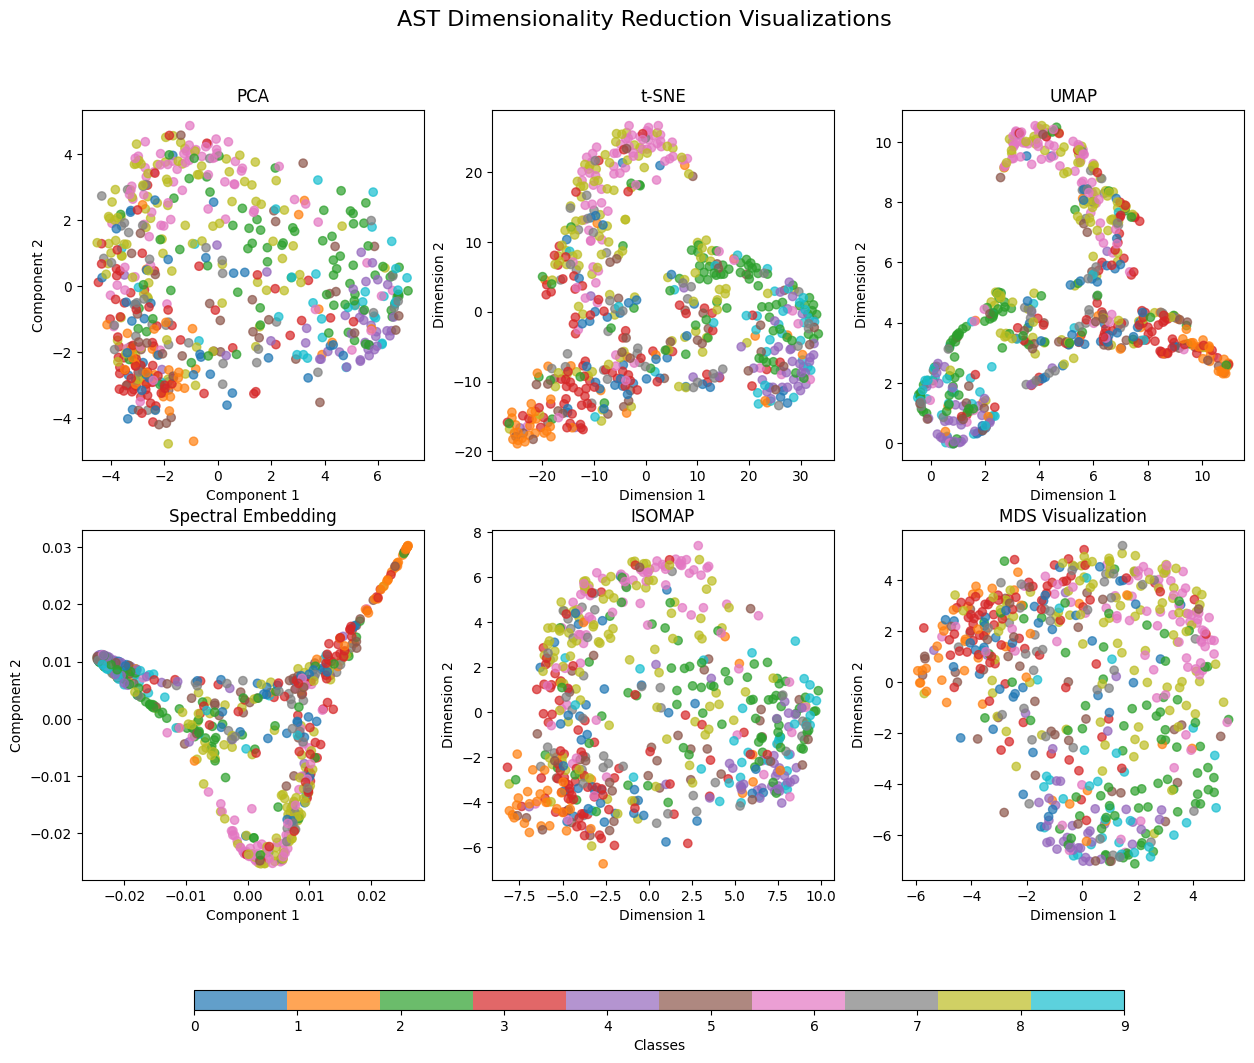

In [10]:
# Extract latent representations
ast_latent_vectors, labels = extract_latent_representations(ast, mel_specs_test_dl, DEVICE, False)

plot_latent_representation("AST", ast_latent_vectors, labels)

In [11]:
del mel_specs_test_data, mel_specs_test_dl

#### Worst model Ever

In [12]:
chroma_test_data = SpectrogramDataset(mel_specs_path, class_mapping=CLASS_MAPPING, train=False, feat_type='chroma', max_length=-1)
chroma_test_dl, _ = torch_train_val_split(dataset=chroma_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)

In [13]:
backbone = LSTMBackbone(chroma_test_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
worst_model = Classifier(NUM_CATEGORIES, backbone).to(DEVICE)
worst_model.load_state_dict(torch.load(model_weights_path+"lstm_genre_chroma.pth", weights_only=True, map_location=DEVICE))

<All keys matched successfully>

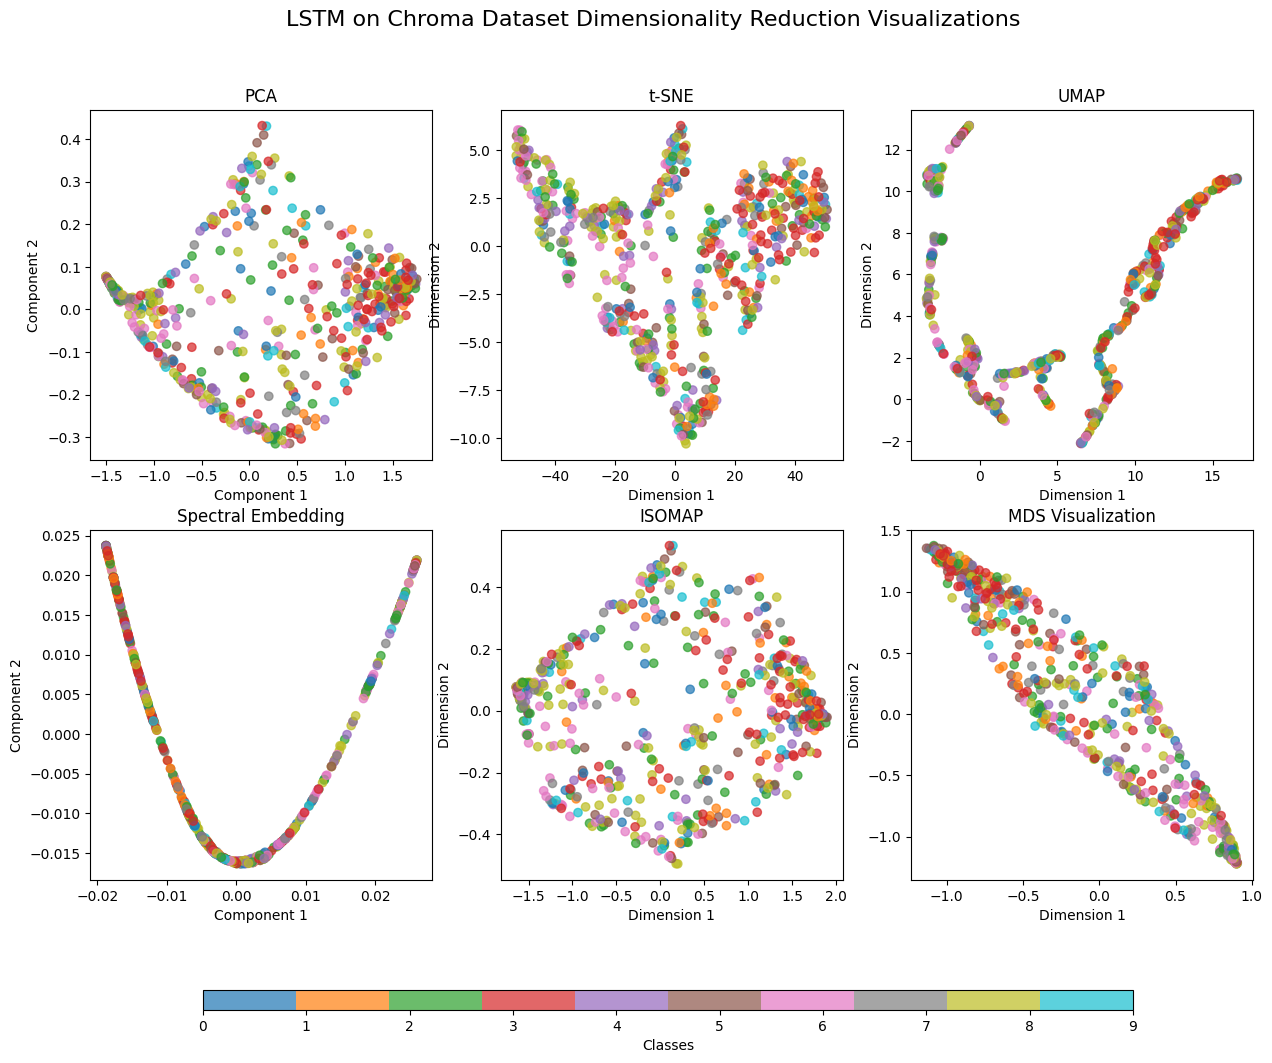

In [14]:
# Extract latent representations
worst_latent_vectors, labels = extract_latent_representations(worst_model, chroma_test_dl, DEVICE, False)

plot_latent_representation("LSTM on Chroma Dataset", worst_latent_vectors, labels)
del chroma_test_dl, chroma_test_data